In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Projection function to ensure the norm of x does not exceed the given radius
def projection_func(x, radius):
    norm_x = np.linalg.norm(x)
    if norm_x == 0:
        return x  # Return x unchanged if its norm is 0
    if norm_x > radius:
        x = (radius / norm_x) * x
    return x


# Sigmoid function and its derivative
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

def sigmoid_prime(t):
    sig = sigmoid(t)
    return sig * (1 - sig)
    
def h(x, A, b, m):
    """
    Compute the function h(x) = (1 / 2m) * sum_{i=1}^{m} (sigmoid(a_i^T x) - b_i)^2
    
    Parameters:
    - x: The input vector (numpy array of shape (p,))
    - A: Matrix of input vectors a_i (numpy array of shape (m, p))
    - b: Vector of output values b_i (numpy array of shape (m,))
    - m: Number of samples
    Returns:
    - h_value: The computed value of the function h(x)
    """
    h_value = (1 / (2 * m)) * np.sum((sigmoid(np.dot(A, x)) - b) ** 2)
    return h_value

# Gradient of h(x)
def grad_h(x, A, b, m):
    """
    Compute the gradient of h(x) using vectorized operations.
    
    ∇h(x) = (1 / m) * A.T * (sigmoid'(A * x) * (sigmoid(A * x) - b))
    
    Parameters:
    - x: The input vector (numpy array of shape (p,))
    - A: Matrix of input vectors a_i (numpy array of shape (m, p))
    - b: Vector of output values b_i (numpy array of shape (m,))
    
    Returns:
    - grad_h: The gradient of h(x) (numpy array of shape (p,))
    """
    # Compute A * x (the inner products for all samples at once)
    inner_products = np.dot(A, x)
    
    # Compute sigmoid(A * x)
    sig = sigmoid(inner_products)
    
    # Compute sigmoid'(A * x)
    sig_prime = sigmoid_prime(inner_products)
    
    # Compute the gradient using vectorized matrix operations
    grad_h = np.dot(A.T, sig_prime * (sig - b)) / m
    
    return grad_h

def generate_normal_vectors_with_norm(m, dim, R):
    """
    Generate m random normal vectors with dimension 'dim', 
    each having a fixed row norm R.
    
    Parameters:
    - m: Number of vectors (rows).
    - dim: Dimension of each vector.
    - R: Desired norm for each vector (row).
    
    Returns:
    - A: Random vectors with shape (m, dim) and norm R for each row.
    """
    # Generate random vectors with normal distribution
    A = np.random.randn(m, dim)  # Normal distribution (mean=0, std=1)
    
    # Normalize each row to have unit norm
    A_norms = np.linalg.norm(A, axis=1, keepdims=True)
    A_unit = A / A_norms
    
    # Scale each vector to have norm R
    A_scaled = R * A_unit
    
    return A_scaled

def generate_normal_varying_solutions(dim, R, x, iter):
    # Generate random vectors with normal distribution
    x_sol = x + (0.1 / np.sqrt(iter+1)) * np.random.randn(dim) 
    p = projection_func(x_sol, R)
    return p


In [3]:
def online_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius,m):
    """
    Online Projected Gradient Descent (OPGD) Algorithm.

    Parameters:
    - grad_h: function to compute the gradient of the objective function at the current point.
    - projection_func: function to project the point back to the feasible set.
    - eta: the learning rate or step size for the gradient descent update.
    - num_iterations: number of iterations to run the algorithm.
    - initial_point: starting point for the algorithm.
    - radius: radius of the feasible set.

    Returns:
    - regret_values: array of cumulative regret values at each iteration.
    """

    # Initialize the point and regret tracking
    x = initial_point
    cumulative_regret = 0
    regret_values = np.zeros(num_iterations)
    dim= len(initial_point)
    x_sol_1 = np.random.randn(dim)         # Generate a random vector
    x_sol_norm = 2*np.linalg.norm(x_sol_1)   # Compute its norm
    x_sol = x_sol_1 / x_sol_norm           # Normalize the vector to have unit norm
    
    for t in range(num_iterations):
        # Randomly generate the parameters for the function g
        A =generate_normal_vectors_with_norm(m, dim, radius)
        b =sigmoid(np.dot(A, x_sol))
        # Update the cumulative regret and store its value
        cumulative_regret += h(x, A, b, m)
        # Compute the gradient at the current point
        grad = grad_h(x, A, b, m)

        # Gradient descent update step
        x = x - eta * grad

        # Projection step to ensure the updated point is within the feasible set
        x = projection_func(x, radius)

        # Update the cumulative regret and store its value
        #cumulative_regret += h(x, a, b)
        regret_values[t] = cumulative_regret
        x_sol = generate_normal_varying_solutions(dim, radius, x_sol, t)
    return regret_values


In [4]:
# Parameters
num_iterations = 2000
radius = 1
dim = 200
delay = 1
Gamma = 0.125
m =1000
kappa = np.minimum(8 * sigmoid_prime(radius), 1)
initial_point_1 = np.random.randn(dim)         # Generate a random vector
initial_point_norm = 2*np.linalg.norm(initial_point_1)   # Compute its norm
initial_point = initial_point_1 / initial_point_norm           # Normalize the vector to have unit norm
factor = 0.99
eta =(2 * kappa* factor) / ((delay+2*np.sqrt(delay)*(delay-1))*Gamma)
regret_values = online_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius,m)

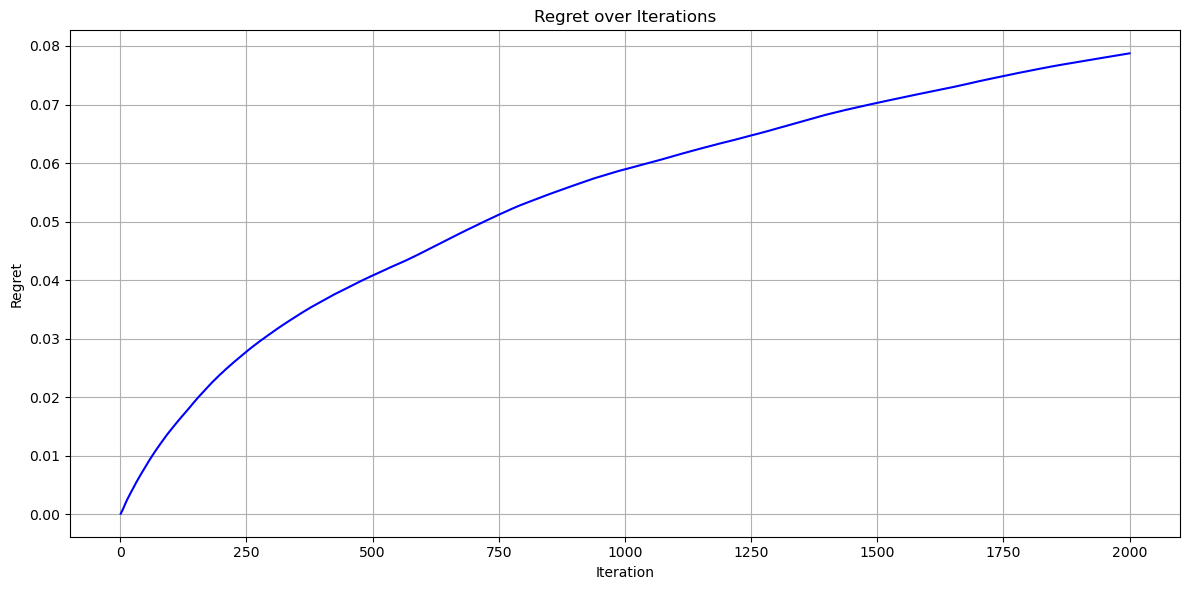

In [5]:
def plot_regret(regret_values, num_iterations):
    iterations = np.arange(1, num_iterations + 1)

    # Plot of regret values over iterations
    plt.figure(figsize=(12, 6))
    
    plt.plot(iterations, regret_values, label='Regret', color='blue')
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Regret')
    plt.grid(True)


    plt.tight_layout()
    plt.show()
# Plot the results
plot_regret(regret_values, num_iterations)

In [6]:
def plot_regrets(cases, grad_h, projection_func, eta, num_iterations, radius, m, vec_delays, max_delay):
    iterations = np.arange(1, num_iterations + 1)
    cases = int(cases)
    
    # To store regret values for multiple cases
    regret_values = np.zeros((num_iterations, cases))
    
    # Running the algorithm for each case
    for i in range(cases):
        initial_point_1 = np.random.randn(dim)         # Generate a random vector
        initial_point_norm = 2*np.linalg.norm(initial_point_1)   # Compute its norm
        initial_point = initial_point_1 / initial_point_norm           # Normalize the vector to have unit norm
        regret_values[:, i] = online_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius,m)
    
    # Compute mean and standard deviation for plotting shaded regions
    mean_regret = np.mean(regret_values, axis=1)
    std_regret = np.std(regret_values, axis=1)

    # Plot of regret values over iterations
    plt.figure(figsize=(10, 6))

    # Plot the mean regret line
    plt.plot(iterations, mean_regret, label='Mean Regret', color='green', lw=2)
    plt.legend(loc='best',fontsize='small')
    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, mean_regret - std_regret, mean_regret + std_regret, 
                     color='green', alpha=0.2, label='Regret ± Std Dev')

    # Add labels and grid
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Averaged regret')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('ogdw12.jpeg')
    plt.show()

In [7]:
def plot_regrets(cases, grad_h, projection_func, eta, num_iterations, radius, m, vec_delays, max_delay):
    iterations = np.arange(1, num_iterations + 1)
    cases = int(cases)
    
    # To store regret values for multiple cases
    regret_values = np.zeros((num_iterations, cases))
    
    # Running the algorithm for each case
    for i in range(cases):
        print(i)
        initial_point_1 = np.random.randn(dim)         # Generate a random vector
        initial_point_norm = 2*np.linalg.norm(initial_point_1)   # Compute its norm
        initial_point = initial_point_1 / initial_point_norm           # Normalize the vector to have unit norm
        regret_values[:, i] = online_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius,m)
    
    # Compute mean and standard deviation for plotting shaded regions
    mean_regret = np.mean(regret_values, axis=1)
    min_regret = np.min(regret_values, axis=1)
    max_regret= np.max(regret_values, axis=1)
    # Plot of regret values over iterations
    plt.figure(figsize=(10, 6))

    # Plot the mean regret line
    plt.plot(iterations, mean_regret, label='Mean Regret', color='green', lw=2)
    plt.legend(loc='best',fontsize='small')
    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, min_regret, max_regret, 
                     color='green', alpha=0.2, label='Regret range')

    # Add labels and grid
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Averaged regret')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('ogdw13.jpeg')
    plt.show()

In [8]:
max_delay = 1
delays = np.random.randint(1, max_delay+1, size=(num_iterations, 1))
# Initialize vec_delays as a list of empty lists
vec_delays = [[] for _ in range(num_iterations + max_delay)]

# Populate vec_delays with the delayed indices
for i in range(num_iterations):
    vec_delays[i + int(delays[i]) - 1].append(i)



C:\Users\cris_\AppData\Local\Temp\ipykernel_14628\820937039.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec_delays[i + int(delays[i]) - 1].append(i)


0
1
2
3
4


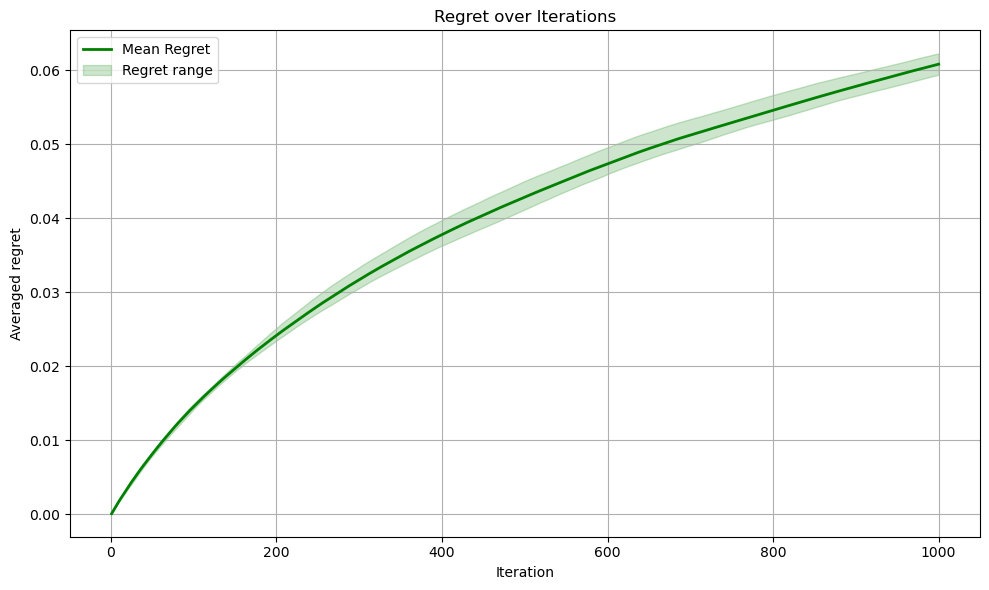

In [9]:
# Parameters
num_iterations = 1000
radius = 1
dim = 200
delay = 1
Gamma = 0.125
m =1000
kappa = np.minimum(8 * sigmoid_prime(radius), 1)
factor = 0.99
eta =(2 * kappa* factor) / ((delay+2*np.sqrt(delay)*(delay-1))*Gamma)
cases = 5
plot_regrets(cases,grad_h, projection_func, eta, num_iterations, radius, m, vec_delays,max_delay)

In [10]:
def online_delayed_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius, m, dim, vec_delays,max_delay):
    """
    Online Delayed Projected Gradient Descent Algorithm.

    Parameters:
    - grad_h: function to compute the gradient of the objective function.
    - projection_func: function to project the point back to the feasible set.
    - eta: the learning rate or step size for the gradient descent update.
    - num_iterations: number of iterations to run the algorithm.
    - initial_point: starting point for the algorithm.
    - radius: radius of the feasible set.
    - vec_delays: list of delays indicating when gradients arrive.

    Returns:
    - regret_values: array of cumulative regret values at each iteration.
    """

    # Initialize the point, regret tracking, and storage for x values
    x = initial_point
    cumulative_regret = 0
    dim= len(initial_point)
    x_sol_1 = np.random.randn(dim)         # Generate a random vector
    x_sol_norm = 2*np.linalg.norm(x_sol_1)   # Compute its norm
    x_sol = x_sol_1 / x_sol_norm           # Normalize the vector to have unit norm
    regret_values = np.zeros(num_iterations)
    vec_iter = np.zeros((len(initial_point), num_iterations + int(max_delay)))

    for t in range(num_iterations+ int(max_delay)):
        grad = np.zeros_like(x)  # Initialize gradient to zero for each iteration
        vec_iter[:, t] = x  # Store the current point x in vec_iter

        # Process delayed gradients that arrive at this time step
        for j in vec_delays[t]:
            # Randomly generate the parameters for the function g
            A =generate_normal_vectors_with_norm(m, dim, radius)
            b =sigmoid(np.dot(A, x_sol))
            # Compute the delayed gradient at the stored point
            x_old = vec_iter[:, j]
            grad += grad_h(x_old, A, b, m)
            
            # Update the regret value based on the delayed information
            regret_values[j] = h(x_old, A, b, m)

        # Gradient descent update step using the accumulated gradient
        x = x - eta * grad

        # Projection step to ensure the updated point is within the feasible set
        x = projection_func(x, radius)
        x_sol = generate_normal_varying_solutions(dim, radius, x_sol, t)
    for k in range(num_iterations):
        # Update the cumulative regret and store its value
        cumulative_regret += regret_values[k]
        regret_values[k] = cumulative_regret

    return regret_values


In [11]:
def plot_regrets_delayed(cases, grad_h, projection_func, eta, num_iterations, radius, m, dim, max_delay):
    iterations = np.arange(1, num_iterations + 1)
    cases = int(cases)
    
    # To store regret values for multiple cases
    regret_values = np.zeros((num_iterations, cases))
    
    # Running the algorithm for each case
    for i in range(cases):
        print(1)
        delays = np.random.randint(1, max_delay+1, size=(num_iterations, 1))
        # Initialize vec_delays as a list of empty lists
        vec_delays = [[] for _ in range(num_iterations + max_delay)]
        # Populate vec_delays with the delayed indices
        for j in range(num_iterations):
            vec_delays[j + int(delays[i]) - 1].append(j)
        initial_point_1 = np.random.randn(dim)         # Generate a random vector
        initial_point_norm = 2*np.linalg.norm(initial_point_1)   # Compute its norm
        initial_point = initial_point_1 / initial_point_norm           # Normalize the vector to have unit norm
        regret_values[:, i] =online_delayed_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius, m, dim, vec_delays,max_delay)
    
    # Compute mean and standard deviation for plotting shaded regions
    mean_regret = np.mean(regret_values, axis=1)
    std_regret = np.std(regret_values, axis=1)

    # Plot of regret values over iterations
    plt.figure(figsize=(10, 6))

    # Plot the mean regret line
    plt.plot(iterations, mean_regret, label='Mean Regret', color='blue', lw=2)
    plt.legend(loc='best',fontsize='small')

    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, mean_regret - std_regret, mean_regret + std_regret, 
                     color='blue', alpha=0.2)

    # Add labels and grid
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Averaged regret')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('delayed12.jpeg')
    plt.show()

1


C:\Users\cris_\AppData\Local\Temp\ipykernel_14628\3278748422.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec_delays[j + int(delays[i]) - 1].append(j)


1
1
1
1


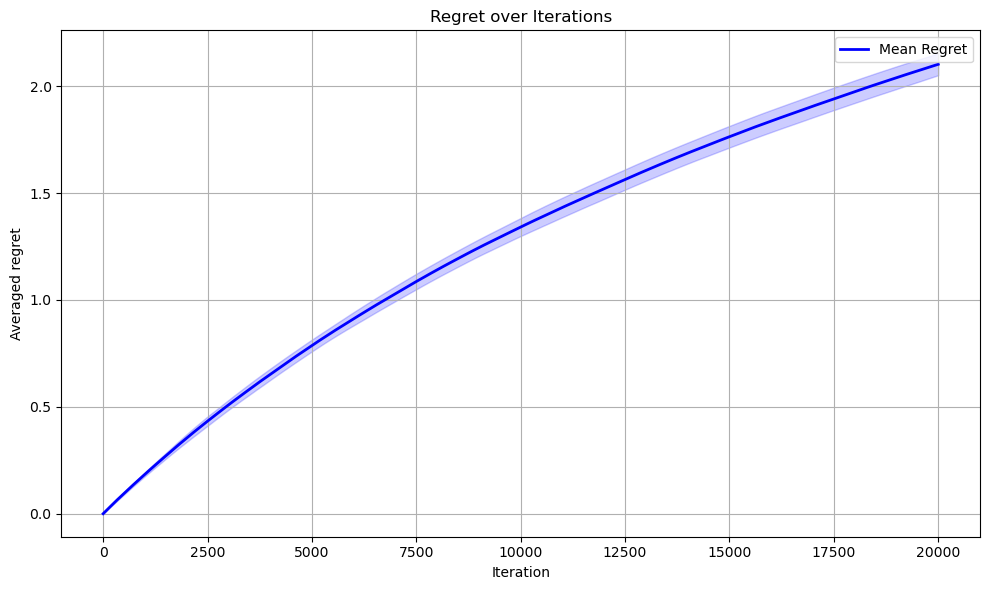

In [12]:
# Parameters
num_iterations = 20000
radius = 1
dim = 200
delay = 10
Gamma = 0.125
m =1000
kappa = np.minimum(8 * sigmoid_prime(radius), 1)
factor = 0.99
eta =(2 * kappa* factor) / ((delay+2*np.sqrt(delay)*(delay-1))*Gamma)
cases = 5
plot_regrets_delayed(cases, grad_h, projection_func, eta, num_iterations, radius, m, dim, delay)

In [13]:
def plot_regrets_delayed(cases, grad_h, projection_func, num_iterations, radius, m, dim, kappa, factor, Gamma):
    iterations = np.arange(1, num_iterations + 1)
    cases = int(cases)
    delays_vec=[1,5,10,20]
    regret_values_delay = np.zeros((num_iterations,len(delays_vec)))
    std_values_delay = np.zeros((num_iterations,len(delays_vec)))
    colors=['aqua', 'maroon','fuchsia','orange','green','yellow']
    count=-1
    for t in delays_vec:
        print(t)
        count=count+1
        # To store regret values for multiple cases
        regret_values = np.zeros((num_iterations, cases))
        # Running the algorithm for each case
        eta =(2 * kappa* factor) / ((t+2*np.sqrt(t)*(t-1))*Gamma)
        for i in range(cases):
            print(i)
            initial_point_1 = np.random.randn(dim)         # Generate a random vector
            initial_point_norm = 2*np.linalg.norm(initial_point_1)   # Compute its norm
            initial_point = initial_point_1 / initial_point_norm           # Normalize the vector to have unit norm
            delays = np.random.randint(1, t+1, size=(num_iterations, 1))
            # Initialize vec_delays as a list of empty lists
            vec_delays = [[] for _ in range(num_iterations + t)]
            # Populate vec_delays with the delayed indices
            for j in range(num_iterations):
                vec_delays[j + int(delays[j]) - 1].append(j)
            regret_values[:, i] = online_delayed_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius, m, dim, vec_delays,t)
    
        # Compute mean and standard deviation for plotting shaded regions
        mean_regret = np.mean(regret_values, axis=1)
        std_regret = np.std(regret_values, axis=1)
        regret_values_delay[:, count] = mean_regret
        std_values_delay[:, count] = std_regret
        # Plot of regret values over iterations
        # plt.figure(figsize=(10, 6))

        # Plot the mean regret line
        plt.plot(iterations, mean_regret, label=f"d={t}", color=colors[count], lw=2)
        plt.legend(loc='best',fontsize='small')
        # Plot shaded area (mean ± std_dev)
        # plt.fill_between(iterations, mean_regret - std_regret, mean_regret + std_regret, 
        #              color=colors[count], alpha=0.2, label=f"Regret ± Std Dev with maximun delay {t}")
        plt.fill_between(iterations, mean_regret - std_regret, mean_regret + std_regret, 
                     color=colors[count], alpha=0.2)

    # Add labels and grid
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Averaged regret')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('Delayed_cases13.jpeg')
    plt.show()
    return regret_values_delay, std_values_delay

1
0


C:\Users\cris_\AppData\Local\Temp\ipykernel_14628\1639409421.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec_delays[j + int(delays[j]) - 1].append(j)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


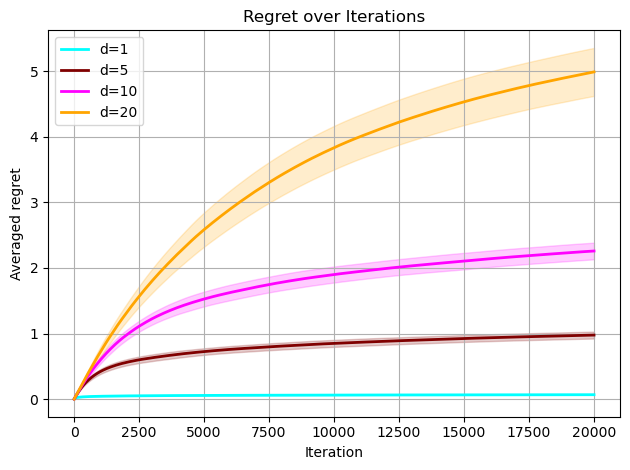

In [14]:
# Parameters
num_iterations = 20000
radius = 1
dim =  50
Gamma = 0.125
m =1000
kappa = np.minimum(8 * sigmoid_prime(radius), 1)
factor = 0.99
cases = 20
regret_values_delay, std_values_delay = plot_regrets_delayed(cases, grad_h, projection_func, num_iterations, radius, m, dim, kappa, factor, Gamma)

In [23]:
tol=1e-4
vec_error= np.zeros((num_iterations,4))
for t in [0,1,2,3]:
    vec_error[0,t]= regret_values_delay[0,t]
    for i in range(num_iterations-1):
        vec_error[i,t]=(regret_values_delay[i+1,t]-regret_values_delay[i,t])
    count=0
    while vec_error[count,t]>tol:
        count=count+1
    print(count)

78
1862
5328
15728


In [24]:
std_values_delay[19999:20000,:]

array([[0.00287446, 0.05268717, 0.12679428, 0.36590524]])

In [32]:
 np.random.randint(1, 10+1,20)

array([ 8,  6,  2,  1,  2,  9,  1,  8,  2,  1,  7,  9,  2, 10,  4,  4,  9,
        6,  8,  9])